# Imports

In [1]:
from copy import deepcopy
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [2]:
# import pyabc

# Define model class

In [3]:
class Model():

    def __init__(self, num_of_agents=10, num_iterations=10, mode ='homogeneous', verbose=False):
        self.agent_types = ['low', 'moderate', 'high'] 
        self.num_of_agents = num_of_agents
        self.num_iterations = num_iterations
        self.mode = mode
        self.verbose = verbose

        #creating lists
        self.num_infected_per_iteration = []
        self.num_low_sus_per_iteration = []
        self.num_mod_sus_per_iteration = []
        self.num_high_sus_per_iteration = []
        
        self.num_of_panicked = 0
        self.panicked_agents = list()
               
        #model time
        self.time = 0
        
        #create the agents, random.choice allocates agents to a type 
        self.agents = []
        for i in range(num_of_agents):
            # adding each new created agent to a list
            if self.mode == 'homogeneous' or self.mode == 'heterogeneous':
                self.agents.append(Agent(self))
            if self.mode == 'adv_heterogeneous':
                self.agents.append(Agent(self, agent_types=random.choice(self.agent_types)))
    
        
        # if the model hasn't finished running yet
        self.model_finished = False 
    
    def get_num_infected(self):
        #gets number of agents that are infected
        return len([ a for a in self.agents if a.state==1 ]) 

    def get_num_low_sus(self):
        return len([ a for a in self.agents if a.state==0 and a.agent_types=='low' ]) 
    
    def get_num_mod_sus(self):
        return len([ a for a in self.agents if a.state==0 and a.agent_types=='moderate' ]) 
    
    def get_num_high_sus(self):
        return len([ a for a in self.agents if a.state==0 and a.agent_types=='high' ]) 
    
    def run(self):
        for t in range(self.num_iterations):
            for agent in self.agents: # every agent, in every iteration, moves forward
                agent.step()
            
            if self.verbose:
                for i, agent in enumerate(self.agents):
                    print('Agent {0}/{1}:'.format(i, self.num_of_agents))    
                    if self.mode == 'homogeneous':
                        print('my likelihood:{}, my state:{}'.format(agent.likelihood, agent.state))
            
            self.num_infected_per_iteration.append(self.get_num_infected())
#             self.num_low_sus_per_iteration.append(self.get_num_low_sus())
#             self.num_mod_sus_per_iteration.append(self.get_num_mod_sus())
#             self.num_high_sus_per_iteration.append(self.get_num_high_sus())
            if self.verbose:
                if self.mode == 'homogeneous' or self.mode == 'heterogeneous':
                    print('step: {},  total infected:{}'.format(t, self.get_num_infected()))
    #             if self.mode == 'adv_heterogeneous':
    #                 print('step: {}, low:{}, mod:{}, high:{}'.format(t, self.get_num_low_sus(), self.get_num_mod_sus(), self.get_num_high_sus()))
    
            #step time
            self.time += 1
        
        #once each iteration is done, model is finished
        self.model_finished = True 
        
        #creating a list of panicked agents, appending new ones after each new step                   
        panicked_agents = list()
        
        for agent in self.agents:
            if agent.state == 1:
                panicked_agents.append(agent)
        self.num_of_panicked = len(panicked_agents)
        self.panicked_agents.append(self.num_of_panicked)

    def graph_num_infected(self):
        """
        Uses matplotlib to create a graph
        """
        if not self.model_finished:
            print("Can't print the number of infected until the model has finished")
            return
        
        # Create a figure and an axis (if you want more than one plot in the same
        # figure you can adjust the subplots function)
        
        fig, ax = plt.subplots(num=None, figsize=(5, 3), dpi=128, facecolor='w', edgecolor='k')
        
        # Do a scatter plot
        if self.mode == 'homogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_infected_per_iteration],
                    c="red", label=" Total infected") 
            
        if self.mode == 'heterogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_infected_per_iteration], "o-",
                    c="red", label=" Total infected") 
            
        if self.mode == 'adv_heterogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_low_sus_per_iteration], "o-",
                    c="green", label="No. Low Sus")
        
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_mod_sus_per_iteration], "o-",
                    c="orange", label="No. Mod Sus")
                
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_high_sus_per_iteration], "o-",
                    c="blue", label="No. High Sus")
        
        ax.set_title("Number of infected per iteration")
        ax.set_ylim(0,len(self.agents)) # limit the y axis
        ax.set_xlabel("Iteration (time)")
        ax.set_ylabel("Number of infected")
        ax.legend(loc='upper left')
        
        plt.savefig("Number of Infected Agents Through Time ", bbox_inches="tight")

## Defining agent class

In [4]:
class Agent():
    
    def __init__(self, model, alpha = 0.1, beta = 0.1, gamma= 0.1, agent_types = 'moderate'):
        
        self.agent_types = agent_types

        self.state = 0
        
        self.alpha = alpha
        
        self.gamma = gamma

        self.beta = beta 
        
        self.likelihood = 0

        
        self.likelihood_heterogeneous_one = []
        self.likelihood_heterogeneous_two = []
        
        #pointer to the model class
        self.model = model
        
        #For the simple heterogenous simulation, 
        #agents draw betas from normal distribution
        if model.mode == ['heterogeneous']:
            self.Beta = self.heterogeneous_model_one_beta

        
        #For the advanced heterogeneous sim, agents are allocated into a 
        #class of susceptibility, according to their agent type
        self.beta_low = self.low_sus()
        self.beta_mod = self.moderate_sus()
        self.beta_high = self.high_sus()

        r = random.random()
        
        #creating a list of all susceptibility classes.
        self.susceptibility = (self.low_sus, self.moderate_sus, self.high_sus) 
        
        if model.mode == ['adv_heterogenous']:
            if self.state == 0: 
                if random.random() <0.5:
                    self.susceptibility = self.low_sus()
                elif random.random() == 0.5:
                    self.susceptibility = self.moderate_sus()
                else:
                    self.susceptibility = self.high_sus()
       
    #Here, we create the different beta functions for the heterogeneous simulations. 
    def low_sus(self):
        return stats.norm.rvs(loc = 0.2, scale = 0.2)
        
    def moderate_sus(self):
        return stats.norm.rvs(loc = 0.4, scale = 0.2)
        
    def high_sus(self):
        return stats.norm.rvs(loc = 0.6, scale = 0.2)

    def heterogeneous_model_one_beta(self):
        return stats.norm.rvs(loc = 0, scale = 1)
    
    #Every time the heterogeneous simulations are ran, we update the betas 
    def update_beta(self):
        self.beta_low = self.low_sus()
        self.beta_mod = self.moderate_sus()
        self.beta_high = self.high_sus()
        
    def prob(self):
        return stats.norm.rvs(loc = 0, scale = 1) 

    def step(self):
        if self.state == 0: 
            self.homogeneous_model()
#             if model.mode == ['heterogeneous']:
#                 self.heterogeneous_model_one()
#           if model.mode ==['adv_heterogeneous']:
#               self.heterogeneous_model_two()
                
        else:
            self.recover()
            # print(self.state)
             
    def homogeneous_model(self):
            
        num_infected = model.get_num_infected()
            
        self.likelihood = self.alpha + (num_infected * self.beta)
        
        r = random.random()
        
        if r < self.likelihood: 
            self.state = 1
         
    def heterogeneous_model_one(self):
        num_infected = model.get_num_infected()
        
        self.likelihood_heterogeneous_one = list()
        
        if model.mode == ['heterogeneous']:
            likelihood = self.alpha + (num_infected * self.heterogeneous_model_one_beta)
            
            if r < likelihood: 
                self.state = 1
            else:
                self.other_agents()
                
            self.likelihood_heterogeneous_one.append(self.likelihood)
    
  
    def heterogeneous_model_two(self):
        num_infected = model.get_num_infected()
        
        self.update_beta()
        
        r = random.random()
        
        self.likelihood_heterogeneous_two = list()
        
        if model.mode == ['adv_heterogeneous']: 
            self.likelihood_low_sus = self.alpha + (num_infected * self.beta_low)
            self.likelihood_moderate_sus = self.alpha + (num_infected* self.beta_mod)
            self.likelihood_high_sus = self.alpha + (num_infected * self.beta_high)
            
            if self.agent_types == 'low':
                if r < self.likelihood_low_sus:
                    self.state = 1
            elif self.agent_types == 'moderate':
                if r < self.likelihood_moderate_sus:
                    self.state = 1
            else: 
                self.agent_types =='high'  
                if r < self.likelihood_high_sus:
                    self.state = 1    
    
            self.likelihoods_low.append(self.likelihood_low_sus)
            self.likelihoods_mod.append(self.likelihood_moderate_sus)
            self.likelihoods_high.append(self.likelihood_high_sus)
            

    def other_agents(self):
        if model.num_of_panicked > model.num_of_agents/1.5:
            self.state = 1
            print("I became panicked after seeing others panic")
            
    
    def recover(self):
        r1 = random.random()
        if self.state == 1:
            if r1 < self.gamma:
                self.state = 0
            if r1 > 0.8:
                self.agent_types == 'low' or self.agent_types == 'moderate'
            
            else:
                self.agent_types =='high'
    

## Running model

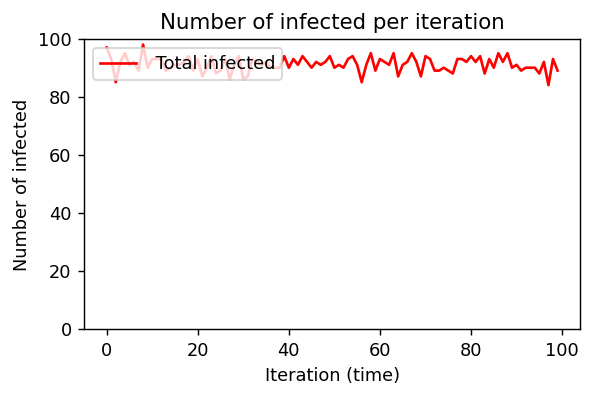

In [5]:
model = Model(num_of_agents=100, num_iterations=100, mode = 'homogeneous')
model.run()
model.graph_num_infected()

In [ ]:
# model = Model(num_of_agents=100, num_iterations=10)
# model.run()
# model.graph_num_infected()

In [ ]:
# get_total = []
# #This runs the model 100 times, each model executing 10 steps.
# for j in range(100):
#     # Run the model
#     Model(num_of_agents=100, num_iterations=100)
#     for i in range(10):
#         model.run()

#     # Store the results
#     for agent in model.agents:
#         get_total.append(model.get_num_infected())

In [ ]:
# plt.rcParams["figure.figsize"] = (20,10)
# plt.rcParams.update({'font.size': 22})

# plt.hist(get_total, color='#0504aa', alpha=0.7, rwidth=0.85)

# plt.grid(axis='y', alpha=0.6)
# plt.xlabel('No. Infected')
# plt.ylabel('Frequency')
# plt.title('Distribution of Number of Infected over Time')

## Creating Datasets for Calibration

In [6]:
get_total = []
#This runs the model 100 times
for j in range(100):
    # Run the model, each model is run 10 times
    base_model = Model(num_of_agents=100, num_iterations=100)
    for k in range(10):
        model = deepcopy(base_model)
        model.run()
        
        for t, i in enumerate(model.num_infected_per_iteration):
            d = {'t': t,
                 'num_infected': i,
                 'copy_number': k,
                 'model_number': j}
            get_total.append(d)

In [7]:
df = pd.DataFrame(get_total)
df.head()

,t,num_infected,copy_number,model_number
0,0,96,0,0
1,1,91,0,0
2,2,88,0,0
3,3,94,0,0
4,4,87,0,0


In [8]:
df['copy_number'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Infected plotting example

In [9]:
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 22})

In [10]:
small_data = df.loc[df['model_number']==0, :]
small_data.shape

(1000, 4)

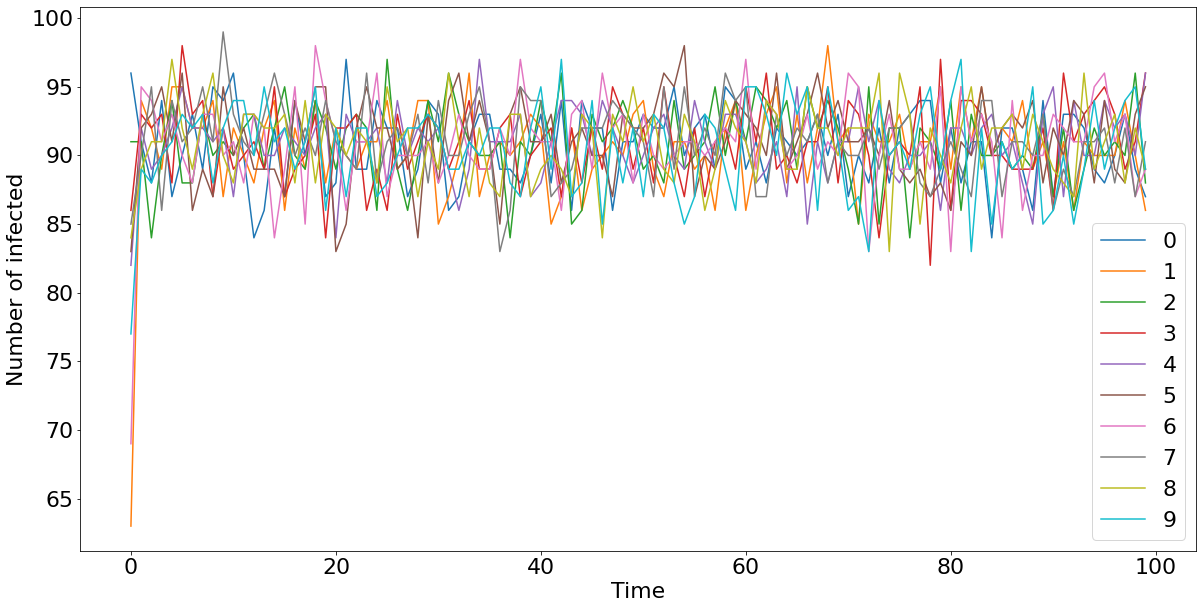

In [11]:
copy_numbers = small_data['copy_number'].unique()

plt.figure()
for copy_number in copy_numbers:
    tdf = small_data.loc[small_data['copy_number']==copy_number, :]
    plt.plot(tdf['t'], tdf['num_infected'], label=copy_number)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number of infected')
plt.show()

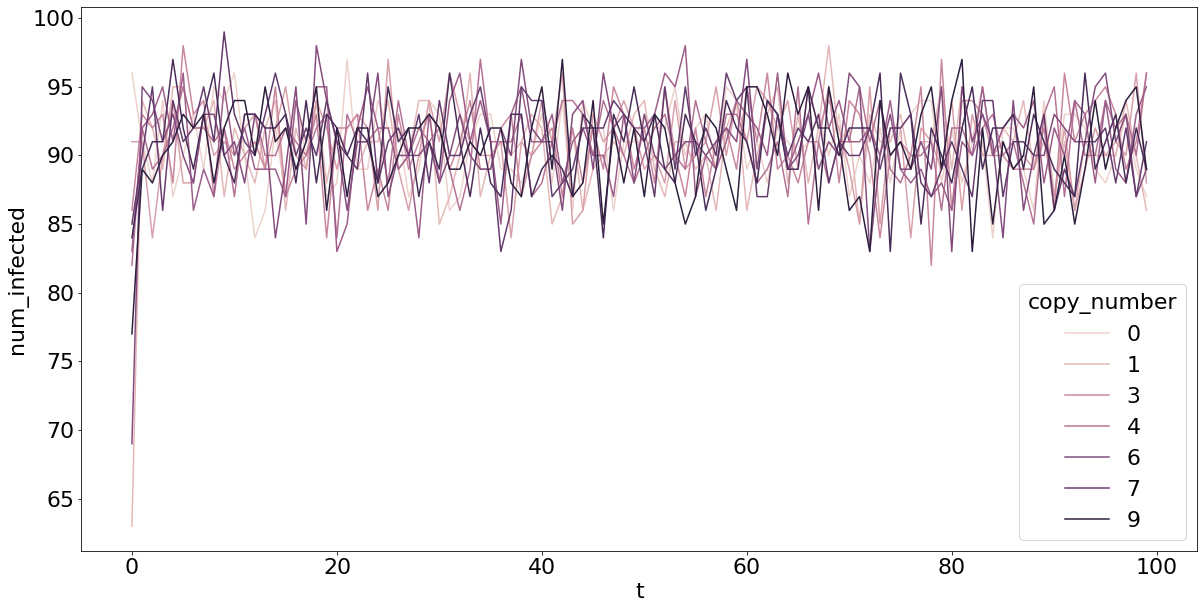

In [12]:
import seaborn as sns
plt.figure()
sns.lineplot(data=small_data, x='t', y='num_infected', hue='copy_number')
plt.show()